In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torchvision
from IPython.display import Image, display


def imshow(img):
    """ndarray 配列をインラインで Notebook 上に表示する。
    """
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

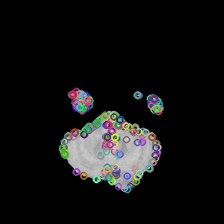

In [9]:
bgr=cv2.imread("./medical_dataset/val/0/1.png")

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(bgr,None)

# compute the descriptors with ORB
kp, des = orb.compute(bgr, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(bgr,kp,None)
imshow(img2)

In [12]:
file_list = ["train", "test", "val"]
train_data=[]
val_data=[]
test_data=[]
image_size=(512,512)

dirname="./medical_dataset/train/0/"
files =os.listdir(dirname)
for fname in files:    #あとはForで1ファイルずつ実行されていく
    bgr = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    #resized = cv2.resize(gray, image_size)
    train_data.append(gray)
train_data=np.array(train_data)

train_data.shape

(4486, 224, 224)

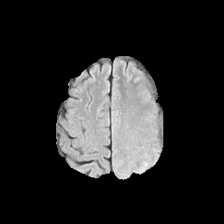

In [14]:
imshow(train_data[1,:,:])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


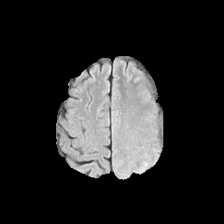

In [23]:
a = torch.tensor(train_data)

print(a[0,:,:])
imshow(a[1,:,:].numpy())

In [24]:
print(torch.cuda.is_available())

True


In [ ]:
# sec: データセット

ds_train = torchvision.datasets.MNIST(root="trains/pytorch-mnist", train=True, download=True, 
    transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
print(len(ds_train))

# sec: 設定

model = TargetNet()
criterion = nn.CrossEntropyLoss()
# case: SGD
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# case: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# case: end
print(model)

In [ ]:
# sec: 学習ループ

model.train()
for i_ep in range(10): # loop over the dataset multiple times

    loss_sum = 0.0
    for ds_i in dl_train:

        inputs, labels = ds_i

        optimizer.zero_grad()
        outputs = model(inputs) # 順伝播
        loss = criterion(outputs, labels)
        loss.backward() # 逆伝播
        optimizer.step()

        loss_sum += loss.item()

    # sec: print

    print('%dep loss: %.5f' % (i_ep + 1, loss_sum / len(ds_train)))

n_ep = i_ep + 1
print('Finished Training')

In [ ]:
# sec: データセット

ds_vali = torchvision.datasets.MNIST(root="trains/pytorch-mnist", train=True, download=True, 
    transform=torchvision.transforms.ToTensor())
ds_vali, _ = torch.utils.data.random_split(ds_vali, [1000, len(ds_vali) - 1000]) # イマイチな書き方
dl_vali = torch.utils.data.DataLoader(ds_vali, batch_size=128, shuffle=False, num_workers=2)
print(len(ds_vali))

In [ ]:
# sec: バリデーション例

model.eval() # 必要 trainのままだとdropoutの効果が残り精度劣化 90.0%で低迷
loss_sum = 0
n_correct = 0
for ds_i in dl_vali:

    inputs, labels = ds_i

    with torch.no_grad():

        outputs = model(inputs) # 順伝播
        loss = criterion(outputs, labels)

        loss_sum += loss.item()

        _, preds = torch.max(outputs, dim=1) # (max values, arg indices)
        n_correct += (preds == labels).sum()

# sec: print

print('loss: %.2e, accuracy: %.2f' % (loss_sum / len(ds_vali), float(n_correct) / len(ds_vali) * 100))

In [ ]:
# sec: 画像を描画

ds_test = torchvision.datasets.MNIST(root="trains/pytorch-mnist", train=False, download=True, 
    transform=torchvision.transforms.ToTensor())

x, label = ds_test[np.random.randint(0, len(ds_test))]
plt.imshow(x[0], cmap='gray', interpolation="none")
plt.show()

# sec: 1回の評価

model.eval()
x = x[None] # 1軸を追加
with torch.no_grad():
    y = model(x)

print("予測ラベル:", y.numpy().argmax(axis=1)[0], "| 真値ラベル:", label)

In [ ]:
# sec: データセット

ds_test = torchvision.datasets.MNIST(root="trains/pytorch-mnist", train=False, download=True, 
    transform=torchvision.transforms.ToTensor())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=128, shuffle=False, num_workers=2)
print(len(ds_test))

In [ ]:
# sec: テスト例

model.eval()
loss_sum = 0
list_pred, list_label = [], []
for ds_i in dl_test:

    inputs, labels = ds_i

    with torch.no_grad():

        outputs = model(inputs) # 順伝播
        loss = criterion(outputs, labels)

        loss_sum += loss.item()

        _, preds = torch.max(outputs, dim=1) # (max values, arg indices)
        list_pred.extend(preds)
        list_label.extend(labels)

list_pred = np.array(list_pred)
list_label = np.array(list_label)

# sec: print

print('loss: %.2e, accuracy: %.2f' % (loss_sum / len(ds_test), (list_pred == list_label).sum() / len(ds_test) * 100))

In [ ]:
# sec: precision, recall, fscore, supportを見る

res_prf = sklearn.metrics.precision_recall_fscore_support(list_label, list_pred)

print("precision, recall, fscore, supportを見る:")
print(res_prf)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) - 0.2, res_prf[0], width=0.4, label="precision")
ax.bar(np.arange(10) + 0.2, res_prf[1], width=0.4, label="recall")
ax.plot(np.arange(10), res_prf[2], 'r_', ms=12, label="f")
ax.legend(fontsize=9, framealpha=0.5, labelspacing=0.2)
ax.set_ylim([0.97, 1.0])
plt.show()

In [ ]:
# sec: 混同行列を見る

sklearn.metrics.confusion_matrix(list_label, list_pred)